<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs</center></h1>

In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. 

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

This lab logs metrics to **Tensorboard**, for instructions to install check the introduction pdf.

Good luck!

---

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from DL_labs.utils.dataset import SegmentationDataset
from DL_labs.utils import dataloader
from DL_labs.utils.model import Model
from config import flying_objects_config
from collections import OrderedDict
import torchvision
from DL_labs.utils import plot, utils
import pprint
import pytorch_lightning as pl
from DL_labs.utils.progressbar import LitProgressBar
import torchmetrics

/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


## Load config
Note that this lab does not support for fineGrained dataset.

In [3]:
cfg = flying_objects_config(False)
cfg

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'GPU': -1,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/'}

# Example Task
Here is an example of how the network can be setup to train a network to learn semantic segmentation of images.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at *https://pytorch.org/vision/stable/transforms.html*

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader.

In [4]:
## Augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), #, 
])

In [5]:
train_dataloader = DataLoader(SegmentationDataset(cfg.training_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(SegmentationDataset(cfg.validation_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
test_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

predict_dataloader = DataLoader(SegmentationDataset(cfg.testing_img_dir, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), predict=True, transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)
print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

**OPTIONAL:** Add RandomFlip to *train_transform*. What happens to the images below?

In [6]:
data = iter(train_dataloader)

x (32, 4, 128, 128) torch.float32 0.0 1.0
y (32, 128, 128) torch.int64 0 3


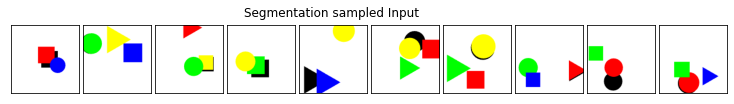

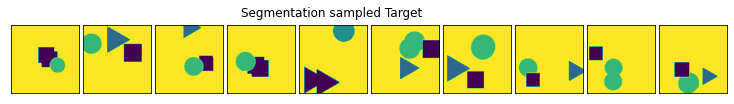

In [23]:
t_x, t_y = next(data)
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Segmentation.data(t_x[:,:3], t_y, nrows=1)

In [24]:
t_x.shape

torch.Size([32, 4, 128, 128])

In [25]:
t_x.permute(0,2,3,1).shape

torch.Size([32, 128, 128, 4])

In [26]:
if False: # Change to true to see statistics
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

In [27]:
pprint.pprint(cfg)

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'GPU': -1,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'NUM_CLASSES': 4,
 'NUM_WORKERS': 4,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/',
 'fineGrained': False,
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation'}


## Create model

In [28]:
class SimpleModel(nn.Module):
    def __init__(self,num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(num_classes, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=2, stride=2),
            nn.LeakyReLU()
        )


    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)

        return x

In [31]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Validation")
}

In [32]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, input_shape=(cfg.IMAGE_CHANNEL, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Test the network on the test dataset
To test the performance for a qualitative estimation we can plot the input, target and the models prediction. This is a good approach to see the performance and understand if the model is close to a correct decision. However, for big data, we probobly want to focus on a qualitative estimation. Therefore we can analyse **Tensorboard** logs to get a better understanding of the model.

In [40]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

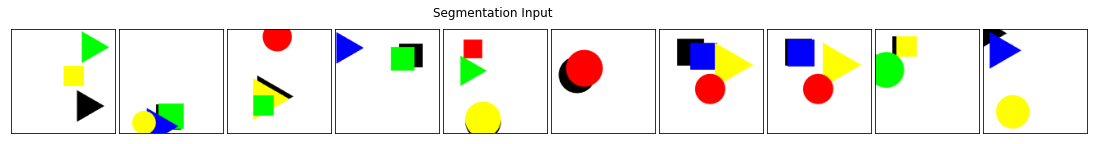

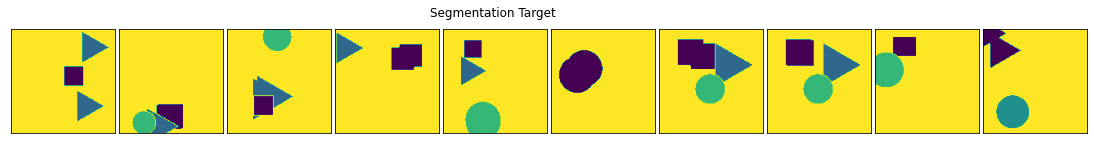

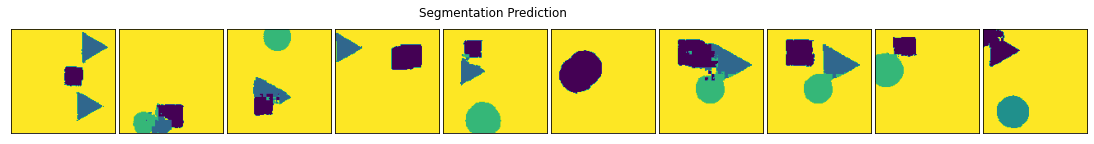

In [44]:
# Take one batch from the test dataset and predict!
t_data, t_segments = next(iter_dataloader)
pred_segments = torch.argmax(modelObj.predict_step(t_data,0,0),dim=1)

plot.Segmentation.results(t_data[:,:3], pred_segments,Y=t_segments, nrows=1, fig_dimension=1.5)

# Exercises

## Architecture
### Task 2
Even if hyperparameter tuning is an simple approach to improve the performance it might not be enough. Try to modify the architecture of the SimpleModel to further increase the performance. Remember that very deep network allow the network to learn many features but if the dataset is to small the model will underfit. A simple dataset should not require a very deep network to learn good features.

**TODO:** Modify the SimpleModel architecture. Force the network to overfit. How bad performance can you get from the network?

**TODO:** Modify the SimpleModel and increase the complexity a little. Does the performance improve? If not, did you modify it to much or to little?

**TODO:** Modify the SimpleModel architecture. Now combine the hyperparameter tuning and modification of the architecture to reach a performance that is close to the truth images. Explain in detail why the change was applied and if it improved the model a lot.

## Hyperparameter tuning
### Task 1
From the example approach we can see that the network performed very poor. For the network to be consider "good" the truth images should match the predicted images. The first task is to tune the parameters of the network. This mostly involves changing the learning rate, optimizers, loss function etc. to better learn features. A network that have a to high learning rate create a increase in variance of the network weights which can make the network unstable.


**TODO:** Perform hyperparameter tuning. Explain in detail why the parameters was changed and why it is considered "better".

## Augmentation
**TODO** Test if data augmentation help. Note that if we want to apply augmentation we need to make sure that the input and target perform the same augmentation. Otherwise, the data will not be correct!

**Question:** Did data augmentation improve the model? \
**Question:** What do you think have the greatest impact on the performance, why? \
**Question:** Does a high accuracy (90%) impy a good model, motivate your answer.

# Report

Summary your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include the result from part 1!

**Name:** \
**Date:** 

## Introduction

## Result